In [1]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")





There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3070 Laptop GPU


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
#device = torch.device("cuda")

In [3]:
from transformers import *

c:\Anaconda3\envs\VS_NLP_2\lib\site-packages\transformers\deepspeed.py:23: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(
c:\Anaconda3\envs\VS_NLP_2\lib\site-packages\transformers\generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
c:\Anaconda3\envs\VS_NLP_2\lib\site-packages\transformers\generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(
c:\Anaconda3\envs\VS_NLP_2\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
 

Źródło:
https://www.kaggle.com/code/harshjain123/bert-for-everyone-tutorial-implementation

In [3]:
df = pd.read_excel('data/vocabularz_2410.xlsx')
df.head()

,text,category,label
0,z czym przychodzicie,pytanie,5
1,tak wiecej kaszlal,objaw,4
2,kaszlal na sucho,objaw,4
3,mial mokry kaszel,objaw,4
4,mial szczekajacy kaszel,objaw,4


In [4]:
# check class distribution
df['label'].value_counts(normalize = True)

label
4    0.300863
5    0.281545
3    0.241677
2    0.067818
0    0.064118
1    0.043979
Name: proportion, dtype: float64

In [5]:
"""
train_text, temp_text, train_pytanie, temp_pytanie,train_odpowiedz, temp_odpowiedz,  = train_test_split(df['text'], df['pytanie'],df['odpowiedz'], 
                                                                    random_state=2018, 
                                                                    test_size=0.8, 
                                                                    stratify=df['odpowiedz'])


val_text, test_text, val_pytanie, test_pytanie, val_odpowiedz, test_odpowiedz = train_test_split(temp_text, temp_pytanie, temp_odpowiedz, 
                                                                random_state=2018, 
                                                                test_size=0.1, 
                                                                stratify=temp_odpowiedz)
"""
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['label'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

Import Bert:

In [6]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')
#bert = BertForMaskedLM.from_pretrained("bert-base-multilingual-cased")
# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
#tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

<Axes: >

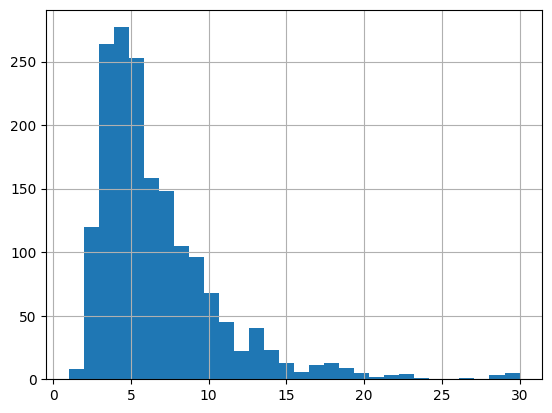

In [7]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)



In [8]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

c:\Anaconda3\envs\VS_NLP_2\lib\site-packages\transformers\tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [9]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [10]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [11]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [12]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        
        self.bert = bert 
        
        # dropout layer
        self.dropout = nn.Dropout(0.1)
      
        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)
      
        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,6)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):
        
        #pass the inputs to the model  
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)
      
        # apply softmax activation
        x = self.softmax(x)

        return x

In [13]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [14]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),lr = 1e-5)

c:\Anaconda3\envs\VS_NLP_2\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [15]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights

class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(train_labels), y = train_labels)

print("Class Weights:",class_weights)

Class Weights: [2.60397554 3.78444444 2.44683908 0.68891586 0.55436198 0.59255393]


In [16]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

In [17]:
# function to train the model
def train():
    
    model.train()
    total_loss, total_accuracy = 0, 0
  
    # empty list to save model predictions
    total_preds=[]
  
    # iterate over batches
    for step,batch in enumerate(train_dataloader):
        
        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
        
        # push the batch to gpu
        batch = [r.to(device) for r in batch]
 
        sent_id, mask, labels = batch
        
        # clear previously calculated gradients 
        model.zero_grad()        

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
  
      # predictions are in the form of (no. of batches, size of batch, no. of classes).
      # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [18]:
# function for evaluating the model
def evaluate():
    
    print("\nEvaluating...")
  
    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0
    
    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step,batch in enumerate(val_dataloader):
        
        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():
            
            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [19]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        #torch.save(model.state_dict(), 'FineTuneBertVocabularz6etykiet.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of     54.

Evaluating...

Training Loss: 1.797
Validation Loss: 1.788

 Epoch 2 / 10
  Batch    50  of     54.

Evaluating...

Training Loss: 1.793
Validation Loss: 1.788

 Epoch 3 / 10
  Batch    50  of     54.

Evaluating...

Training Loss: 1.793
Validation Loss: 1.787

 Epoch 4 / 10
  Batch    50  of     54.

Evaluating...

Training Loss: 1.795
Validation Loss: 1.787

 Epoch 5 / 10
  Batch    50  of     54.

Evaluating...

Training Loss: 1.791
Validation Loss: 1.787

 Epoch 6 / 10
  Batch    50  of     54.

Evaluating...

Training Loss: 1.789
Validation Loss: 1.786

 Epoch 7 / 10
  Batch    50  of     54.

Evaluating...

Training Loss: 1.786
Validation Loss: 1.787

 Epoch 8 / 10
  Batch    50  of     54.

Evaluating...

Training Loss: 1.791
Validation Loss: 1.786

 Epoch 9 / 10
  Batch    50  of     54.

Evaluating...

Training Loss: 1.788
Validation Loss: 1.785

 Epoch 10 / 10
  Batch    50  of     54.

Evaluating...

Training Loss: 1.785
Validation L

In [21]:
#load weights of best model
path = 'FineTuneBertVocabularz6etykiet.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [22]:
# get predictions for test data
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

In [23]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.00      0.00      0.00        16
           2       0.14      0.42      0.22        24
           3       0.28      0.27      0.27        88
           4       0.30      0.12      0.17       110
           5       0.35      0.54      0.43       103

    accuracy                           0.28       365
   macro avg       0.18      0.23      0.18       365
weighted avg       0.26      0.28      0.25       365



c:\Anaconda3\envs\VS_NLP_2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda3\envs\VS_NLP_2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda3\envs\VS_NLP_2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
example_text = "poszliśmy do doktor Krztoń,"
bert_input = tokenizer(example_text,padding='max_length', max_length = 512, 
                       truncation=True, return_tensors="pt")


use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


input = bert_input['input_ids'].squeeze(1).to(device)


mask = bert_input['attention_mask'].to(device)
result = model(input, mask)
score = (result.argmax(dim=1))
score = score.tolist()

print("wynik dla zadanego tekstu :", score[0], "a to jest :")

if score[0]==0: 
    print('badanie')
elif score[0]==1: 
    print('czestotliwosc')
elif score[0]==2: 
    print('diagnostyka')
elif score[0]==3: 
    print('lek')
elif score[0]==4:
    print('objaw')
elif score[0]==5: 
    print('pytanie')


wynik dla zadanego tekstu : 5 a to jest :
pytanie
